# Using Trotterization to solve the time-dependent Schrödinger equation on the superconducting backends of Quantum Inspire

**Authors:** Marios Samiotis (m.samiotis@tudelft.nl)

**Date:** June 8, 2025

# 1. Introduction

In this notebook, we will explore the simulation of the time-dependent Schrödinger equation for a simple 2-spin system using one of the superconducting backends available on the Quantum Inspire 2.0 platform.

For optimal performance, make sure that you are running this notebook within a customized Python 3.12 environment which includes the packages "quantuminspire" and "qiskit-quantuminspire" [(installation instructions)](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/README.md).

This is an advanced tutorial intended for users who are already familiar with using the superconducting backends of Quantum Inspire for their own experiments. If you are a beginner, we recommend going through the Getting Started guides for either [Starmon-7](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/getting_started_starmon7.ipynb) or [Tuna-5](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/blob/main/getting_started_tuna5.ipynb) before continuing with this notebook.

NOTE: in order to run the custom functions from utility_functions.py, you will need to clone the entire repository QuantumInspireUtilities from [https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/tree/main](https://github.com/DiCarloLab-Delft/QuantumInspireUtilities/tree/main).

First, we will run the following cell in order to login to the Quantum Inspire platform. You will need an account in order to login to the platform.

In [1]:
! qi login "https://api.quantum-inspire.com"

Please continue logging in by opening: https://auth.quantum-inspire.com/activate?user_code=WGJM-TKLW in your browser
If promped to verify a code, please confirm it is as follows: WGJM-TKLW
Login successful!
Using member ID 10


The following cell runs all necessary imports,

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
import qiskit.quantum_info as qi

from qiskit_quantuminspire.qi_provider import QIProvider

from qi_utilities.utility_functions.circuit_modifiers import apply_readout_circuit
from qi_utilities.algorithms.trotterization import construct_trotterization_circuit

from qi_utilities.utility_functions.ro_correction import split_raw_shots, extract_ro_assignment_matrix, plot_ro_assignment_matrix
from qi_utilities.utility_functions.midcircuit_msmt import get_multi_qubit_counts, get_multi_qubit_prob, extract_observable_values_Z_basis
from qi_utilities.utility_functions.ro_correction import ro_corrected_multi_qubit_prob
from qi_utilities.utility_functions.result_processing import return_raw_data

from qi_utilities.classical_solvers.time_evolution import simulate_time_evolution

# 2. Connect to a Quantum Inspire backend

We will first need to connect to the Quantum Inspire provider, by running the following cell,

In [3]:
provider = QIProvider()

You may see the full list of all available backends of Quantum Inspire platform by running

In [4]:
provider.backends()

[<qiskit_quantuminspire.qi_backend.QIBackend object at 0x154e57860 (name=QX emulator, id=1)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x16d7e6a20 (name=Starmon-7, id=3)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x10520ae10 (name=Tuna-5, id=4)>,
 <qiskit_quantuminspire.qi_backend.QIBackend object at 0x16b382f30 (name=Ry emulator, id=5)>]

We now connect to either of the backends Starmon-7 or Tuna-5 by running the following cell,

In [5]:
backend_name = "Starmon-7" # 'Starmon-7' or 'Tuna-5'
backend = provider.get_backend(name=backend_name)

By running the cell below, one can print the connectivity (otherwise known as "coupling map") of the processor,

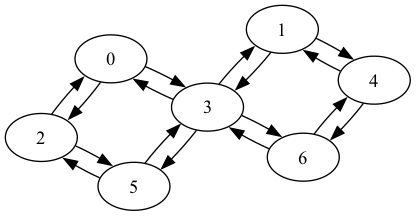

In [17]:
backend.coupling_map.draw()

# 3. Trotterization in a nutshell

For any closed quantum system, the state of the system is described by the state vector $| \psi \rangle$, and the dynamical evolution in time $t$ of the system under the influence of a [Hamiltonian](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)) $\hat{H}$ is governed by the Schrödinger equation,

$$i \hbar |\psi(t) \rangle = \hat{H} |\psi(t)\rangle.$$

When concerned with the [Schrödinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation), we distinguish between the solutions $|\psi_{i}\rangle$ and the corresponding allowed energies $E_{i}$ of the eigenvalue problem (Eq. 1), and the general time-dependent solution $|\psi(t)\rangle$ (Eq. 2) for an initial state of the system $|\psi(0) \rangle$,

$$\hat{H}|\psi_{i}\rangle = E_{i}|\psi_{i}\rangle \text{ (1), eigenvalue problem}$$
$$|\psi(t) \rangle = \exp(-i\hat{H}t/\hbar)|\psi(0)\rangle \text{ (2), general solution}$$

We wish to simulate the time evolution of an initial quantum state $|\psi(0)\rangle$ of two spins, under the influence of the [Heisenberg (anti)ferromagnetic Hamiltonian](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model) with no external magnetic field applied, where

$$ \hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)\text{ (3)}. $$

We distinguish between two cases:

$$\text{1. }J<0, \text{ ferromagnetic interaction}$$
$$\text{2. }J>0, \text{ antiferromagnetic interaction}$$

Here we will study the later case, the antiferromagnetic interaction between two opposite spins. We note here that the interaction strength $J$ defined above is in S.I. units of [Hz].

We use the mapping convention for the spin-up and spin-down states of a spin $|\uparrow\text{}\rangle\longleftrightarrow |0\rangle$ and $|\downarrow\text{} \rangle \longleftrightarrow |1\rangle$ to the qubit computational states respectively. Therefore for an initial state of two anti-aligned spins, $|\psi(0)\rangle = |01\rangle$. Due to the nature of the interaction, as is described in Eq. (3) for $J>0$, we expect the two spins to evolve opposite to each other in time, transitioning smoothly from the state $|01\rangle$ to $|10\rangle$ and back to $|01\rangle$, with a revolution frequency proportional to $J$.

Inserting Eq. (3) into Eq. (2), we have

$$|\psi(t) \rangle = \exp(-i(\hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z})Jt)|01\rangle \text{ (4)}.$$

Using the [Trotter-Suzuki decomposition](https://en.wikipedia.org/wiki/Hamiltonian_simulation#Product_formulas),

$$ \exp(-i(\hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z})Jt) \approx \left( \exp(-i\hat{X}\hat{X}Jt/n) \exp(-i\hat{Y}\hat{Y}Jt/n) \exp(-i\hat{Z}\hat{Z}Jt/n) \right)^{n} \text{ (5)},$$

where $n$ is called the Trotter step.

Each of the exponentials in Eq. (5) is a two-qubit unitary gate, and in the half-angle rotation they can be expressed as

$$ R_{XX} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{X}\hat{X}Jt/n)\text{, }R_{YY} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{Y}\hat{Y}Jt/n)\text{, }R_{ZZ} \left(\frac{2Jt}{n} \right) = \exp(-i\hat{Z}\hat{Z}Jt/n),$$

and so Eq. (4) becomes

$$ |\psi(t) \rangle \approx \left( R_{XX} \left(\frac{2Jt}{n} \right) R_{YY} \left(\frac{2Jt}{n} \right) R_{ZZ} \left(\frac{2Jt}{n} \right) \right)^{n} |01\rangle,$$

which at the limit of large $n$ becomes an equality.

For devices where error correction is not applicable, there is always a trade-off that we need to consider; as we increase the Trotter step size $n$, the accuracy of the simulation increases, but at the cost of larger circuit depths which are detrimental to the overall performance of the algorithm on a noisy device. In this guide notebook we will be using the step size $n=1$, and ultimately we will be executing the circuit

$$ |\psi(t) \rangle \approx R_{XX}(2Jt) R_{YY}(2Jt) R_{ZZ} (2Jt) |01\rangle\text{ (6)}.$$

# 4. Constructing the Trotterization circuits

## 4.1. Defining the problem Hamiltonian

In [7]:
nr_qubits = 2
J = 10e6 # in units of [Hz]

In [8]:
pauli_terms = ['XX', 'YY', 'ZZ']
pauli_coefficients = [J, J, J]

hamiltonian_operator = qi.SparsePauliOp(pauli_terms, pauli_coefficients)
print(hamiltonian_operator)

SparsePauliOp(['XX', 'YY', 'ZZ'],
              coeffs=[10000000.+0.j, 10000000.+0.j, 10000000.+0.j])


## 4.2. Defining the simulation parameters and circuits

In [9]:
trotter_order = 1
evolution_times = np.linspace(0.0, 0.5 * np.pi / J, 27)
initial_state = '01'
measured_observable = 'ZZ'

# 5. [SOLUTION METHOD 1] Compile all circuits into a single job

## 5.1. Construct separately all circuits and group them all together

In [ ]:
qc_list = []

for time_step in range(len(evolution_times)):
    qc = QuantumCircuit(nr_qubits, nr_qubits,
                        name=f"trotterization_heisenberg_{measured_observable}_timestep_{time_step}")
    qc_step = construct_trotterization_circuit(nr_qubits,
                                    initial_state,
                                    measured_observable,
                                    hamiltonian_operator,
                                    trotter_order,
                                    evolution_times,
                                    time_step=time_step)
    qc = qc.compose(qc_step)
    qc_list.append(qc)

qc_list[0] = apply_readout_circuit(qc_list[0], list(range(nr_qubits)))

In [ ]:
qc_list[0].draw('mpl')

## 5.2. Transpile all circuits

In [ ]:
starmon7_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'barrier', 'delay', 'reset']
qubit_priority_list = [0, 2, 1, 3, 4, 5, 6]

transpiled_qc_list = []
for qc_idx in range(len(qc_list)):
    qc_transpiled = transpile(qc_list[qc_idx],
                              backend,
                              initial_layout=qubit_priority_list[0:qc.num_qubits],
                              basis_gates=starmon7_basis_gates)
    
    transpiled_qc_list.append(qc_transpiled)

## 5.3. Submit the job and collect the results

In [ ]:
nr_shots = 2**12
job = backend.run(transpiled_qc_list, shots=nr_shots, memory=True)
result = job.result(timeout = 600)

## 5.4. Results post-processing

### 5.4.1. Extract readout assignment matrix

In [ ]:
raw_data_shots_per_circuit = []

qubit_list = [qubit_priority_list[0], qubit_priority_list[1]]

raw_data_shots_0, ro_mitigation_shots = split_raw_shots(result, qubit_list, circuit_nr=0)
raw_data_shots_per_circuit.append(raw_data_shots_0)
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, qubit_list)

for circuit_idx in range(1, len(qc_list)):
    raw_data_shots = return_raw_data(qc_list[1], result, circuit_idx)
    raw_data_shots_per_circuit.append(raw_data_shots)

In [ ]:
raw_data_probs_per_circuit = []
ro_corrected_probs_per_circuit = []

for circuit_idx in range(len(qc_list)):
    raw_data_counts = get_multi_qubit_counts(raw_data_shots_per_circuit[circuit_idx], len(qubit_list))

    raw_data_probs = get_multi_qubit_prob(raw_data_counts)
    raw_data_probs_per_circuit.append(raw_data_probs[0])

    ro_corrected_probs = ro_corrected_multi_qubit_prob(raw_data_probs, ro_assignment_matrix, qubit_list)
    ro_corrected_probs_per_circuit.append(ro_corrected_probs[0])

In [ ]:
plot_ro_assignment_matrix(ro_assignment_matrix, qubit_list)

### 5.4.2. Gather experimental results and apply readout error mitigation

In [ ]:
IZ_values = extract_observable_values_Z_basis(raw_data_probs_per_circuit, 'IZ', nr_qubits)
ZI_values = extract_observable_values_Z_basis(raw_data_probs_per_circuit, 'ZI', nr_qubits)

IZ_values_ro_corrected = extract_observable_values_Z_basis(ro_corrected_probs_per_circuit, 'IZ', nr_qubits)
ZI_values_ro_corrected = extract_observable_values_Z_basis(ro_corrected_probs_per_circuit, 'ZI', nr_qubits)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')

ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))

plt.tight_layout()
plt.show()

## 5.5. Compare experimental results with exact solution

In [ ]:
initial_state_qc = QuantumCircuit(2)
# Initialization to the |01> state
if len(initial_state) != nr_qubits:
    raise ValueError('Initial state must have same number of qubits defined.')
for idx in range(len(initial_state)):
    if initial_state[idx] == '1':
        initial_state_qc.x((nr_qubits-1) - idx)

observables = simulate_time_evolution(initial_state_qc,
                                      hamiltonian_operator,
                                      evolution_times,
                                      ['IZ', 'ZI'])

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')
ax.plot(evolution_times*1e9, observables['IZ']['values'], label=r'$\langle IZ \rangle$ exact solution', color='C0', linestyle='--')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')
ax.plot(evolution_times*1e9, observables['ZI']['values'], label=r'$\langle ZI \rangle$ exact solution', color='C1', linestyle='--')

ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))

plt.tight_layout()
plt.show()

# 6. [SOLUTION METHOD 2] Stitch all circuits into one using mid-circuit measurements

## 6.1. Create a single circuit with all time evolution steps

In [10]:
qc = QuantumCircuit(nr_qubits, nr_qubits*len(evolution_times), name=f"trotterization_heisenberg_{measured_observable}")

for time_step in range(len(evolution_times)):
    qc_step = construct_trotterization_circuit(nr_qubits,
                                    initial_state,
                                    measured_observable,
                                    hamiltonian_operator,
                                    trotter_order,
                                    evolution_times,
                                    time_step=time_step,
                                    midcircuit_measurement = True)
    qc = qc.compose(qc_step)

qc = apply_readout_circuit(qc, list(range(nr_qubits)))

In [ ]:
qc.draw('mpl')

## 6.2 Transpile all circuits

In [11]:
starmon7_basis_gates = ['id', 'z', 's', 'sdg', 't', 'tdg', 'x', 'rx', 'y', 'ry', 'cz', 'barrier', 'delay', 'reset']
qubit_priority_list = [0, 2, 1, 3, 4, 5, 6]

qc_transpiled = transpile(qc,
                          backend,
                          initial_layout=qubit_priority_list[0:qc.num_qubits],
                          basis_gates=starmon7_basis_gates)

In [ ]:
qc_transpiled.draw('mpl')

## 6.3. Submit the job and collect the results

In [12]:
nr_shots = 2**12
job = backend.run(qc_transpiled, shots=nr_shots, memory=True)
result = job.result(timeout = 600)

## 6.4 Results post-processing

### 6.4.1. Extract readout assignment matrix

In [13]:
qubit_list = [qubit_priority_list[0], qubit_priority_list[1]]

raw_data_shots, ro_mitigation_shots = split_raw_shots(result, qubit_list)

In [14]:
ro_assignment_matrix = extract_ro_assignment_matrix(ro_mitigation_shots, qubit_list)

raw_data_counts = get_multi_qubit_counts(raw_data_shots, len(qubit_list))
raw_data_probs = get_multi_qubit_prob(raw_data_counts)
ro_corrected_probs = ro_corrected_multi_qubit_prob(raw_data_probs, ro_assignment_matrix, qubit_list)

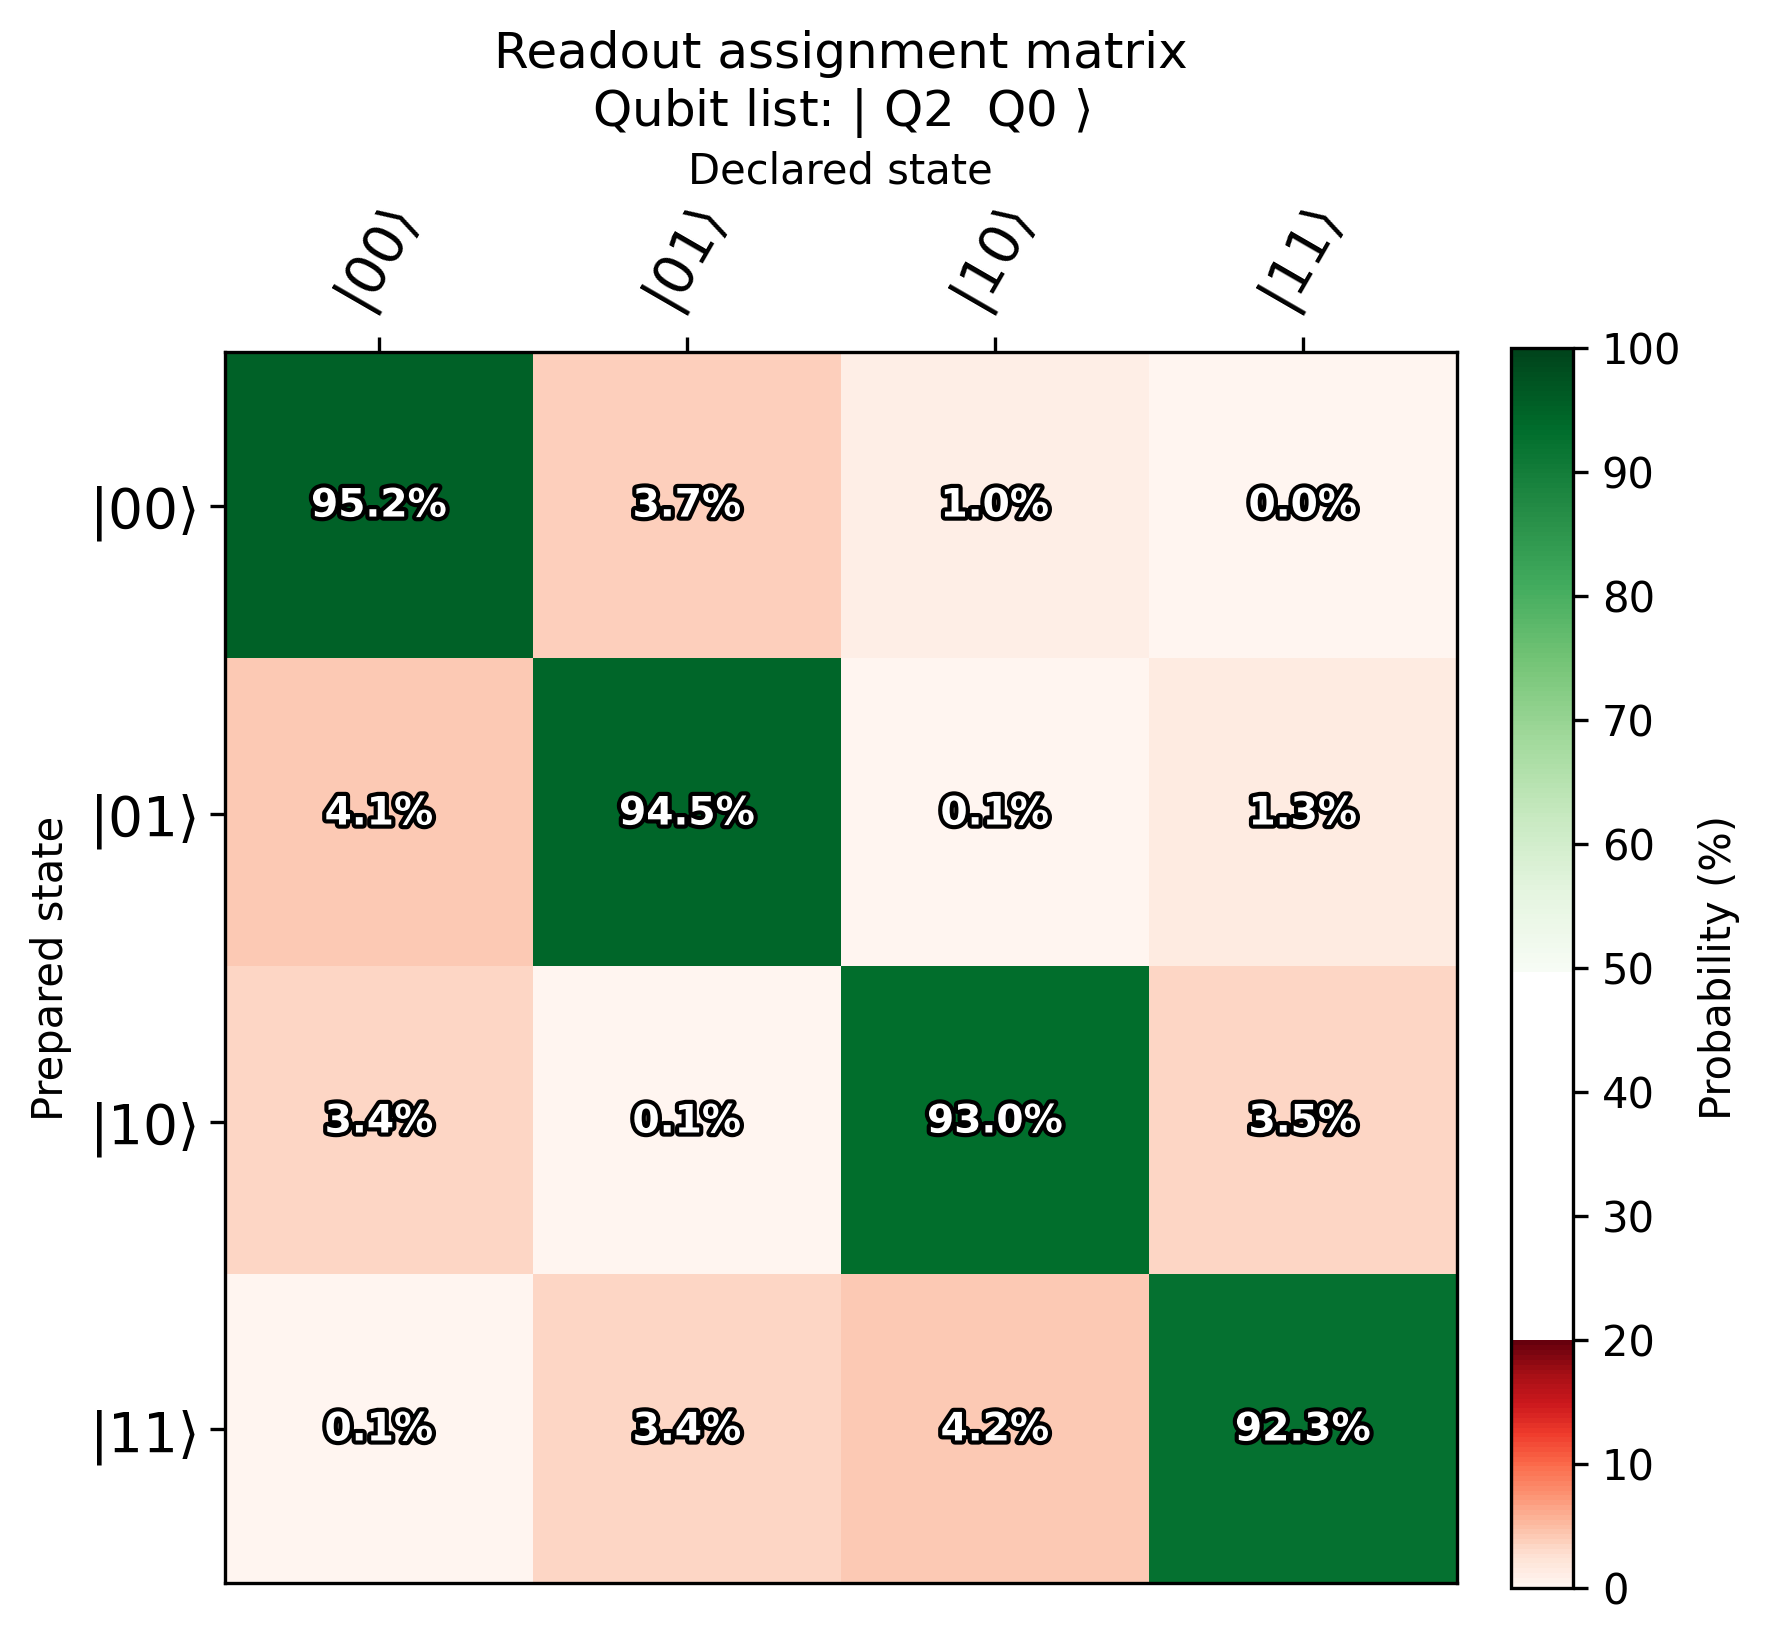

In [15]:
plot_ro_assignment_matrix(ro_assignment_matrix, qubit_list)

### 6.4.2. Gather experimental results and apply readout error mitigation

In [18]:
IZ_values = extract_observable_values_Z_basis(raw_data_probs, 'IZ', nr_qubits)
ZI_values = extract_observable_values_Z_basis(raw_data_probs, 'ZI', nr_qubits)

IZ_values_ro_corrected = extract_observable_values_Z_basis(ro_corrected_probs, 'IZ', nr_qubits)
ZI_values_ro_corrected = extract_observable_values_Z_basis(ro_corrected_probs, 'ZI', nr_qubits)

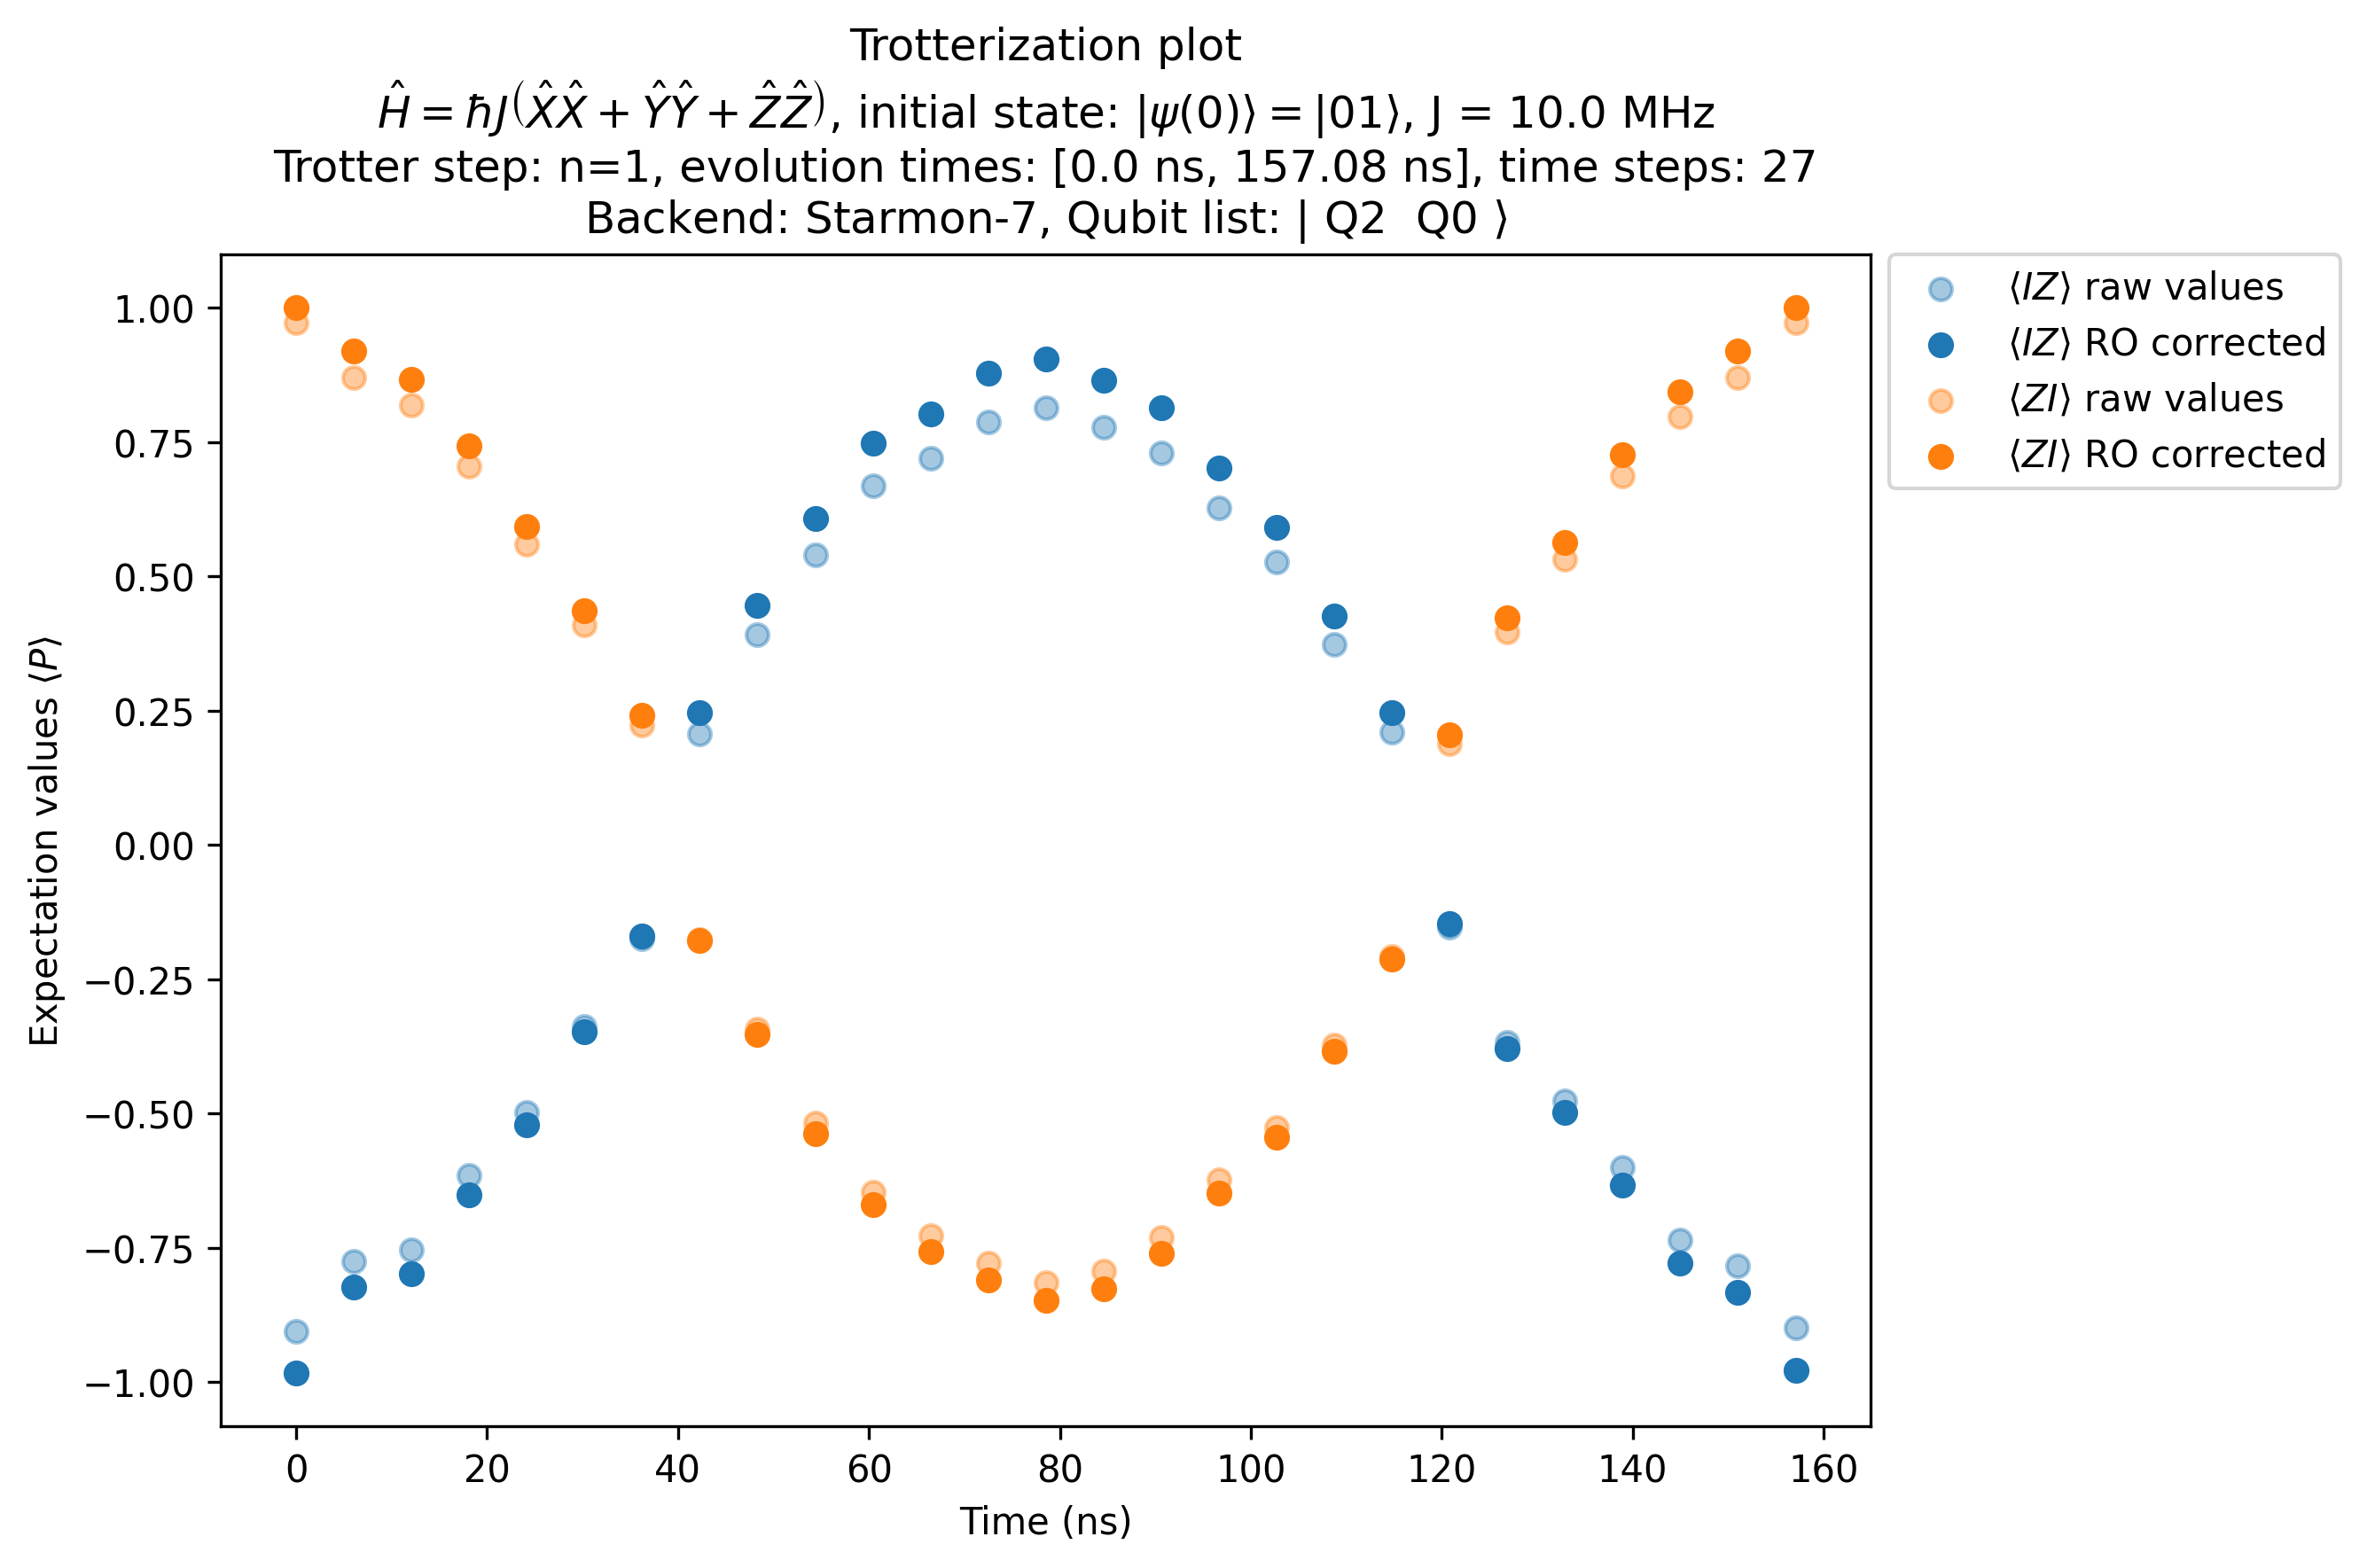

In [21]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.9))

plt.tight_layout()
plt.show()

## 6.5. Compare simulation results with exact solution

In [22]:
initial_state_qc = QuantumCircuit(2)
# Initialization to the |01> state
if len(initial_state) != nr_qubits:
    raise ValueError('Initial state must have same number of qubits defined.')
for idx in range(len(initial_state)):
    if initial_state[idx] == '1':
        initial_state_qc.x((nr_qubits-1) - idx)

observables = simulate_time_evolution(initial_state_qc,
                                      hamiltonian_operator,
                                      evolution_times,
                                      ['IZ', 'ZI'])

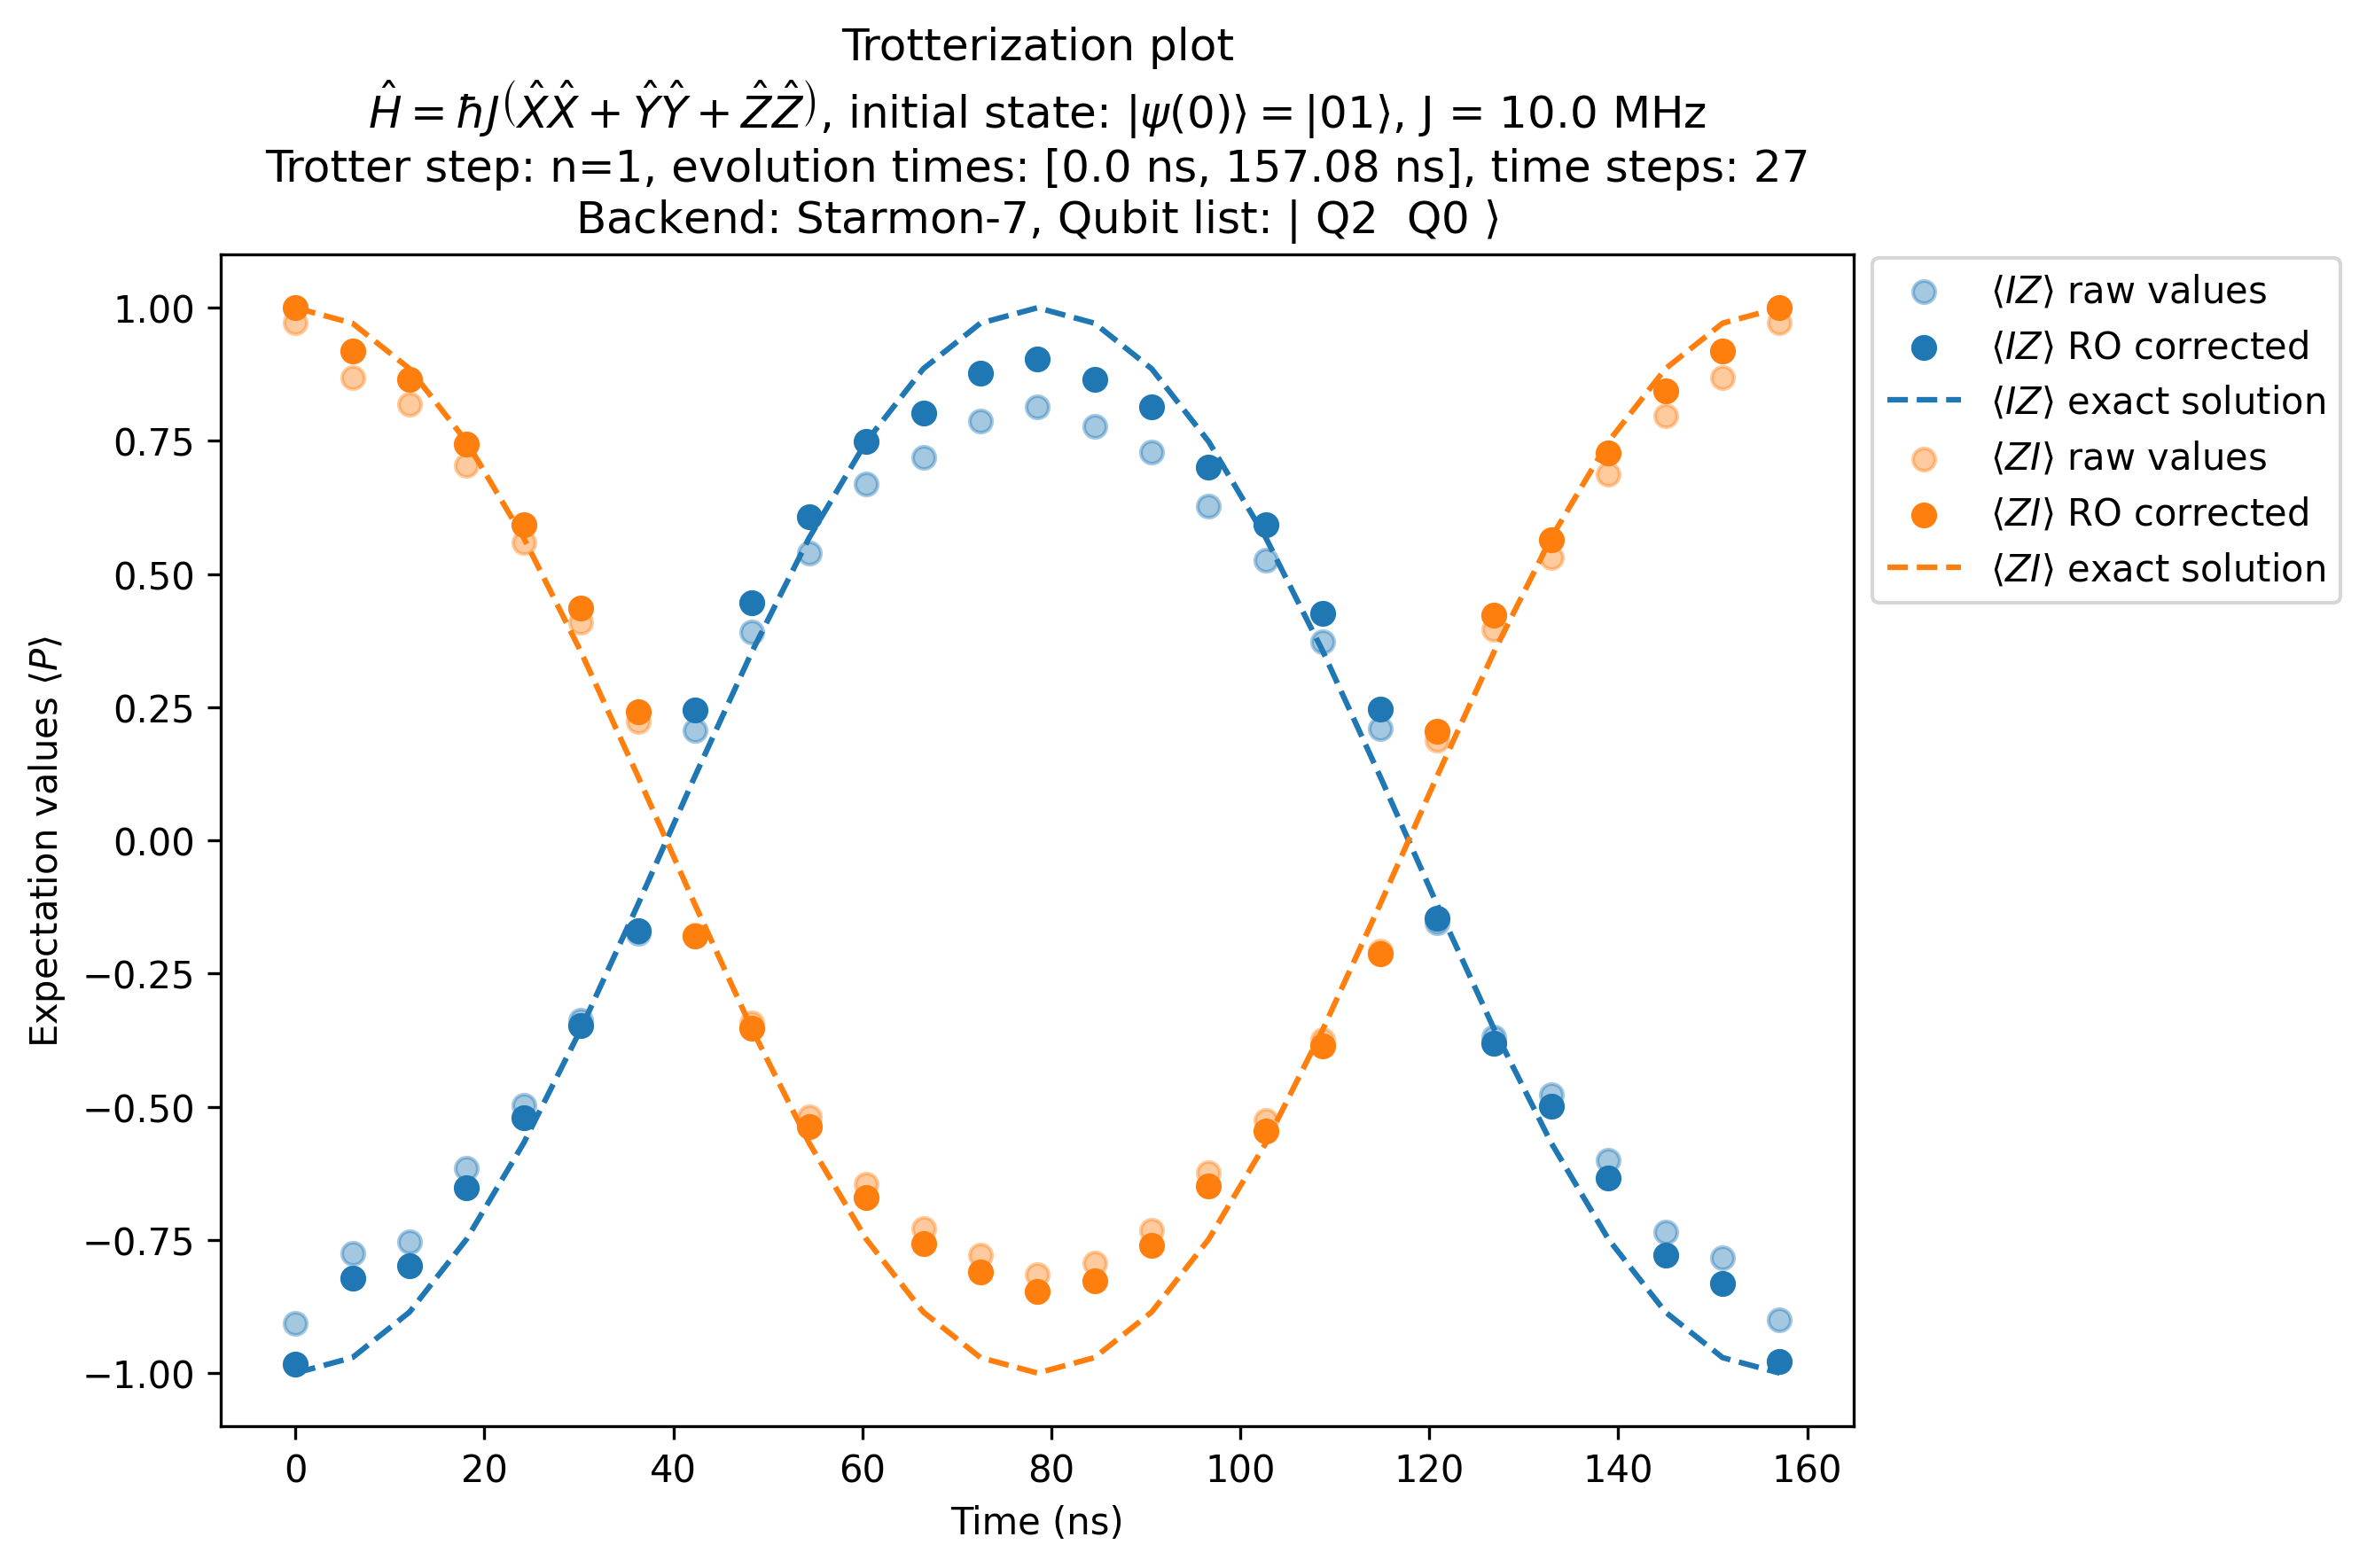

In [24]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)

ax.scatter(evolution_times*1e9, IZ_values, label=r'$\langle IZ \rangle$ raw values', color='C0', alpha=0.4)
ax.scatter(evolution_times*1e9, IZ_values_ro_corrected, label=r'$\langle IZ \rangle$ RO corrected', color='C0')
ax.plot(evolution_times*1e9, observables['IZ']['values'], label=r'$\langle IZ \rangle$ exact solution', color='C0', linestyle='--')

ax.scatter(evolution_times*1e9, ZI_values, label=r'$\langle ZI \rangle$ raw values', color='C1', alpha=0.4)
ax.scatter(evolution_times*1e9, ZI_values_ro_corrected, label=r'$\langle ZI \rangle$ RO corrected', color='C1')
ax.plot(evolution_times*1e9, observables['ZI']['values'], label=r'$\langle ZI \rangle$ exact solution', color='C1', linestyle='--')

qubit_list_label = r"$|$"
for qubit_idx in qubit_list[::-1]:
   qubit_list_label += f" Q{qubit_idx} "
qubit_list_label += r"$\rangle$"
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'Expectation values $\langle P \rangle $')
ax.set_title('Trotterization plot\n' \
             r'$\hat{H} = \hbar J \left( \hat{X}\hat{X} + \hat{Y}\hat{Y} + \hat{Z}\hat{Z} \right)$, ' \
             r'initial state: $|\psi(0) \rangle = |$' f'{initial_state}' r'$\rangle$, ' r'J = ' f'{J/1e6} MHz' \
             f'\nTrotter step: n={trotter_order}, evolution times: [{np.round(evolution_times[0]*1e9, 2)} ns, ' \
                f'{np.round(evolution_times[-1]*1e9, 2)} ns], time steps: {len(evolution_times)}\n' \
             f'Backend: {result.backend_name}, Qubit list: {qubit_list_label}')

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.85))

plt.tight_layout()
plt.show()